In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [4]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [5]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

In [6]:
df = traer_df()
df = preparar_dataset(df)
X, y = dividir_dataset(df)
X = aplicar_one_hot_encoding(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [8]:
clf_1 = KNeighborsClassifier()
clf_2 = DecisionTreeClassifier()
clf_3 = SVC(C=200, kernel='rbf', gamma=0.1,probability=True)

In [9]:
voting = VotingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)], voting='soft'
)

In [10]:
X_train, X_test = normalizar_datos(X_train, X_test)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('clf_1', KNeighborsClassifier()),
                             ('clf_2', DecisionTreeClassifier()),
                             ('clf_3',
                              SVC(C=200, gamma=0.1, probability=True))],
                 voting='soft')

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.88      0.91      0.89      6159
   Tiene Alto Valor Adquisitivo       0.68      0.60      0.64      1982

                       accuracy                           0.84      8141
                      macro avg       0.78      0.75      0.77      8141
                   weighted avg       0.83      0.84      0.83      8141



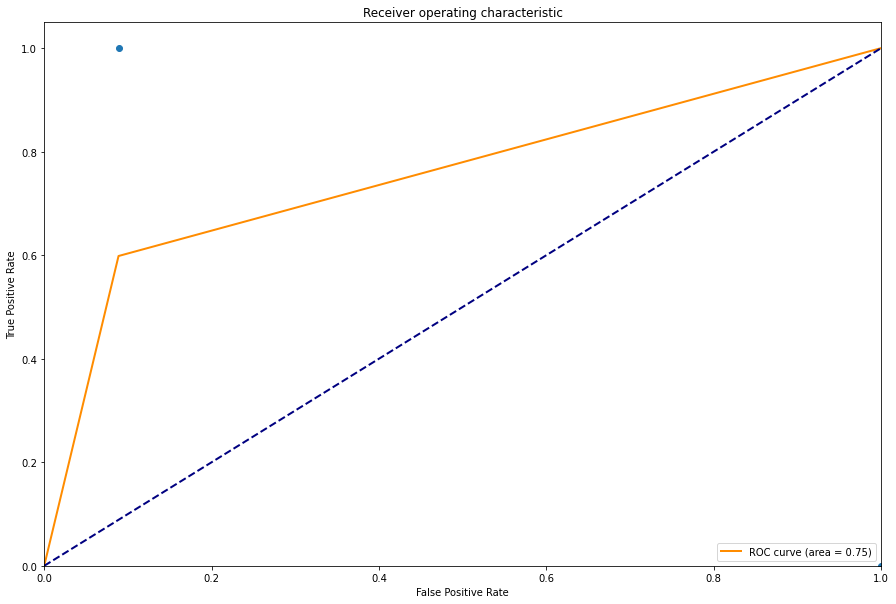

0.7547861751050902

In [11]:
y_pred = voting.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo']))
graficar_auc_roc(y_test,y_pred)